# Vanilla propagation
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

In [3]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im

def save_gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    im =save_image(gradient)
    return im

def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [4]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None

        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [7]:
def VanillaBackprop_process(model, img):
  VBP = VanillaBackprop(model)
  im, pred_cls = process_img(img, model)
  gradient = VBP.generate_gradients(im, pred_cls)
  grad_im =save_gradient_images(gradient)
  grad_bn= convert_to_grayscale(gradient)
  grad_im_bn =save_gradient_images(grad_bn)
  return grad_im, grad_im_bn

def download_images(images, captions, cols = 3, rows = 1):
    n_img = len(images)
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]))
    plt.tight_layout()

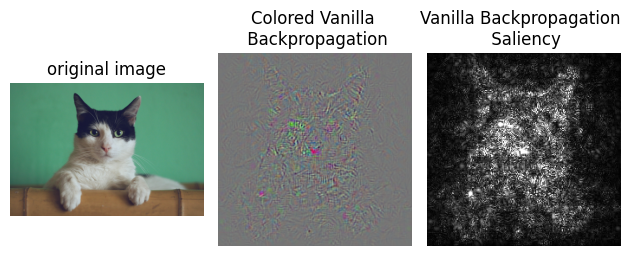

In [10]:

im, im1 =VanillaBackprop_process(pret_mod, img)
images = [img,im, im1]
captions = ['original image', 'Colored Vanilla \n Backpropagation', 'Vanilla Backpropagation \n Saliency']
fig = download_images(images, captions, cols = 3, rows = 1)